In [1]:
import matplotlib.pyplot as plt
import pandas as pd
from astropy.table import Table
import os
import numpy as np
# import cartopy.crs as ccrs
import json
import os
import seaborn as sns
from astropy.table import Table

In [2]:
os.chdir('/home/walml/repos/zoobot')

Pretend this is the final decals catalog

In [3]:
latest_export = pd.read_csv('/home/walml/Downloads/classifications_200520.csv')  # Tobias offline aggregated classifications

In [4]:
latest_export = latest_export.dropna(subset=['iauname'])  # a few test uploads don't have iaunames, we want to remove these (and would remove below anyway) but lets keep nan out of the iaunames ot remove set

In [118]:
to_upload = Table.read('/media/walml/beta/galaxy_zoo/decals/catalogs/dr5_nsa1_0_0_to_upload.fits').to_pandas()  # joint catalog, after selection cuts
to_upload['iauname'] = to_upload['iauname'].str.decode('utf8')



In [119]:
#dr1/2 raw classifications
dr1_c = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/gzreduction_ouroborous/working_dir/raw/classifications/2017-10-15_galaxy_zoo_decals_classifications.csv')
dr2_c = pd.read_csv('/media/walml/beta/galaxy_zoo/decals/gzreduction_ouroborous/working_dir/raw/classifications/2017-10-15_galaxy_zoo_decals_dr2_classifications.csv')


## Remove galaxies with classifications that we shouldn't publish 

In [120]:
bad_iaunames = set()  

In [121]:
# and in decals, passed selection cuts, implicitly. Removes some test uploads, some of whcih have nan iaunames
good_images = latest_export['iauname'].isin(to_upload.query('fits_filled')['iauname'])  
good_images.value_counts()

True     227126
False     12556
Name: iauname, dtype: int64

In [122]:
to_upload.columns.values

array(['iauname', 'nsa_id', 'ra', 'dec', 'petrotheta', 'petroth50',
       'petroth90', 'z', 'fits_loc', 'png_loc', 'fits_ready',
       'fits_filled', 'png_ready'], dtype=object)

In [123]:
to_upload = to_upload.rename(index=str, columns={
    'fits_loc': 'local_fits_loc',
    'png_loc': 'local_png_loc'
})
                       

In [124]:
to_upload['local_png_loc']

0         b'/Volumes/EXTERNAL/decals/png/dr5/J094/J09465...
1         b'/Volumes/EXTERNAL/decals/png/dr5/J094/J09463...
2         b'/Volumes/EXTERNAL/decals/png/dr5/J094/J09463...
3         b'/Volumes/EXTERNAL/decals/png/dr5/J094/J09474...
4         b'/Volumes/EXTERNAL/decals/png/dr5/J094/J09475...
                                ...                        
343123    b'/Volumes/EXTERNAL/decals/png/dr5/J230/J23092...
343124    b'/Volumes/EXTERNAL/decals/png/dr5/J235/J23510...
343125    b'/Volumes/EXTERNAL/decals/png/dr5/J235/J23524...
343126    b'/Volumes/EXTERNAL/decals/png/dr5/J235/J23532...
343127    b'/Volumes/EXTERNAL/decals/png/dr5/J235/J23541...
Name: local_png_loc, Length: 343128, dtype: object

In [125]:
to_upload['png_loc'] = to_upload['local_png_loc'].str.decode('utf-8')
 

In [126]:
to_upload['png_loc'] = to_upload['png_loc'].str.replace('/Volumes/EXTERNAL/decals/png/', 'png_native/')  

In [127]:
to_upload['png_loc']

0         png_native/dr5/J094/J094651.40-010228.5.png
1         png_native/dr5/J094/J094630.85-004554.5.png
2         png_native/dr5/J094/J094631.59-005917.7.png
3         png_native/dr5/J094/J094744.18-004013.4.png
4         png_native/dr5/J094/J094751.74-003242.0.png
                             ...                     
343123    png_native/dr5/J230/J230924.60-001458.1.png
343124    png_native/dr5/J235/J235101.08-100042.7.png
343125    png_native/dr5/J235/J235247.10-105259.6.png
343126    png_native/dr5/J235/J235320.91-103238.7.png
343127    png_native/dr5/J235/J235414.90-101409.4.png
Name: png_loc, Length: 343128, dtype: object

In [128]:
to_upload.query('fits_filled').to_csv('final_dr5_uploadable_catalog.csv', index=False)  # use for master catalog

In [129]:
bad_iaunames = bad_iaunames.union(set(latest_export[~good_images]['iauname']))

In [130]:
len(bad_iaunames)

12556

In [131]:
np.sum(latest_export[good_images]['iauname'].duplicated())

0

## Flag galaxies with earlier question versions (bulge, merger)

In [12]:
# merger_v1_answers = ['merging_both-v1', 'merging_neither-v1',
#        'merging_tidal-debris-v1']
# bulge_size_v1_answers = ['bulge-size_obvious-v1',
#        'bulge-size_tiny-v1', 'bulge-size_none-v1']

In [13]:
# has_v1_bulge_answers = latest_export[bulge_size_v1_answers].sum(axis=1) > 0
# has_v1_bulge_answers.value_counts()

KeyError: "None of [Index(['bulge-size_obvious-v1', 'bulge-size_tiny-v1', 'bulge-size_none-v1'], dtype='object')] are in the [columns]"

Let's just drop that guy and not worry about it

In [ ]:
# has_v1_merger_answers = latest_export[merger_v1_answers].sum(axis=1) > 0
# has_v1_merger_answers.value_counts()

Enough of those that we should probably publish.

Check they only ever have v1, not both:

In [ ]:
# merger_v2_answers = ['merging_none', # from renamed from neither
#                      'merging_minor-disturbance', # new
#                      'merging_major-disturbance', # new
#                      'merging_merger'] # unchanged?

# new_v2_answers = ['merging_none', # from renamed from neither
#                      'merging_minor-disturbance', # new
#                      'merging_major-disturbance']

# shared_merger_answers = ['merging_merger']

# # has_v2_merger_answers = latest_export[merger_v2_answers].sum(axis=1) > 0
# # (has_v2_merger_answers & has_v1_merger_answers).sum()

# has_new_merger_answers = latest_export[new_v2_answers].sum(axis=1) > 0

# print(has_new_merger_answers.mean())
# print(has_v1_merger_answers.mean())
# print((has_new_merger_answers & has_v1_merger_answers).mean())

Okay, that's awkward - 5% of galaxies have answers for *both* v1 answers *and* the new v2 answers...
I think that for clarity it would be best to wipe the v1 answers for galaxies with both.

In [ ]:
# has_both = has_new_merger_answers & has_v1_merger_answers

In [ ]:

# latest_export.loc[has_both, merger_v1_answers] = 0

# # check modifying slice still worked
# has_new_merger_answers = latest_export[new_v2_answers].sum(axis=1) > 0
# has_v1_merger_answers = latest_export[merger_v1_answers].sum(axis=1) > 0
# (has_new_merger_answers & has_v1_merger_answers).mean()

In [ ]:
# with open('data/bad_iaunames.json', 'w') as f:
#     json.dump(list(bad_iaunames), f)

# Flag galaxies by origin

In [14]:
calibration_subject_sets = [
    19829,  # nair 250 each
    19832  # nair all
]

pre_active_subject_sets = [
    20036,  # first 3k
    20156, # 3k-5k,
    20603,  # 5k
    21156, # 10k
    51756, # 3k
    60259,  # 5k
    60995, # +5k   
    67383,  # +15k,
    67382,  # +500
    74807  # decals classic subjects, going to include as 'pre-active'
]

targeted_observations = [
    20354, # yjan 790
    60258  # yjan 1100ish (id/date is a touch strange)
]    

active_random = [74905]

active_priority = [74909]

# and will add the newly-found galaxies to active_random

In [15]:
set_namer = {
    'calibration_nair_dr2_dr5': calibration_subject_sets,
    'pre_active': pre_active_subject_sets,
    'targeted': targeted_observations,
    'active_random': active_random,
    'active_priority': active_priority
}

I need to check the vote distribution for active learning vs random. If it worked right, there should be more featured galaxies in priority set.

In [16]:
latest_subjects = pd.read_csv('/home/walml/repos/gz-panoptes-reduction/data/latest_subjects_export.csv')

In [17]:
latest_subjects = latest_subjects[latest_subjects['workflow_id'].isin([6122.0, 10582.0, 10581.0])]  # decals public workflows
latest_subjects['workflow_id'].value_counts()

6122.0     230381
10582.0    204763
10581.0     19866
Name: workflow_id, dtype: int64

In [18]:
latest_subjects = latest_subjects[~latest_subjects['subject_set_id'].isin([77652])]  # remove eagle subjects
latest_subjects['workflow_id'].value_counts()  # eagle is 15k in each of normal and enhanced workflows

6122.0     230381
10582.0    190662
10581.0      5765
Name: workflow_id, dtype: int64

In [19]:
latest_subjects['subject_set_id'].value_counts()

74905    357026
67383     15000
74909     10048
21156     10000
74807      5765
60259      5000
20603      5000
60995      5000
19832      3202
20036      3000
51756      3000
20156      2000
60258       977
20354       790
19829       500
67382       500
Name: subject_set_id, dtype: int64

In [20]:
latest_subjects['metadata'] = latest_subjects['metadata'].apply(json.loads)

In [21]:
def get_iauname(metadata):
    possible_keys = ['iauname', '!iauname', 'IAUNAME', '!IAUNAME']
    for key in possible_keys:
        if key in metadata.keys():
            return metadata[key]
    return np.nan

In [22]:
latest_subjects['iauname'] = latest_subjects['metadata'].apply(get_iauname)

In [23]:
pd.isna(latest_subjects['iauname']).sum()

0

In [24]:
latest_subjects['subject_set_id'].value_counts()

74905    357026
67383     15000
74909     10048
21156     10000
74807      5765
60259      5000
20603      5000
60995      5000
19832      3202
20036      3000
51756      3000
20156      2000
60258       977
20354       790
19829       500
67382       500
Name: subject_set_id, dtype: int64

In [25]:
expected_sets = set(calibration_subject_sets + pre_active_subject_sets + targeted_observations + active_random + active_priority)
actual_sets = set(latest_subjects['subject_set_id'].unique())


In [26]:
expected_sets

{19829,
 19832,
 20036,
 20156,
 20354,
 20603,
 21156,
 51756,
 60258,
 60259,
 60995,
 67382,
 67383,
 74807,
 74905,
 74909}

In [27]:
actual_sets

{19829,
 19832,
 20036,
 20156,
 20354,
 20603,
 21156,
 51756,
 60258,
 60259,
 60995,
 67382,
 67383,
 74807,
 74905,
 74909}

In [28]:
actual_sets.difference(expected_sets)

set()

In [29]:
# 74807 is an early active-learning-random upload with bad metadata and can be cut (any lost galaxies should be replaced)
# https://www.zooniverse.org/lab/5733/subject-sets/74807

In [30]:
classic_ids = latest_subjects.query('subject_set_id == "74807"')['subject_id']

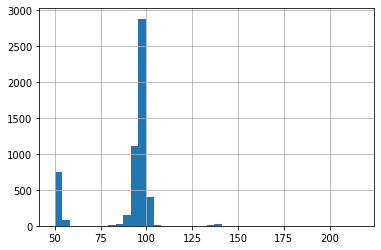

In [31]:
good_export = latest_export[good_images]
good_export[good_export['subject_id'].isin(classic_ids)]['smooth-or-featured_total-votes'].hist(bins=40)

In [32]:
latest_subjects.query('subject_set_id == "74807"')['metadata'].iloc[5]

{'!ra': 146.60722345852503,
 '!dec': -1.2407756685509388,
 '!nsa_id': 11,
 '!iauname': 'J094625.73-011426.7',
 '!file_loc': '/Volumes/alpha/decals/png_native/dr5/J094/J094625.73-011426.7.png',
 '!redshift': 0.0906017,
 '!petroth50': 4.337675599999999,
 '!petroth90': 14.22231,
 '!petrotheta': 10.695449,
 '!fits_filled': True,
 '!nsa_version': 'v1_0_0',
 '!sdss_search': '[Click to view in SDSS](+tab+http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=146.60722345852503&dec=-1.2407756685509388&scale=0.1&width=120&height=120&opt=)',
 '#upload_date': '2019-04-12',
 '!decals_search': '[Click to view in DECALS](+tab+http://www.legacysurvey.org/viewer?ra=146.60722345852503&dec=-1.2407756685509388&zoom=15&layer=decals-dr5)',
 '!local_png_loc': '/Volumes/alpha/decals/png_native/dr5/J094/J094625.73-011426.7.png',
 '!simbad_search': '[Click to search SIMBAD](+tab+http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=146.60722345852503+%09-1.2407756685509388&CooFrame=FK5&CooEpoch=2000&CooEqui=2000

In [33]:
latest_subjects.query('subject_set_id == "74905"')['metadata'].iloc[0]

{'!ra': 146.93412887297967,
 '!dec': -0.6704053610430766,
 '!nsa_id': 3,
 '!iauname': 'J094744.18-004013.4',
 '!file_loc': '/Volumes/alpha/decals/png_native/dr5/J094/J094744.18-004013.4.png',
 '!redshift': 0.121270485,
 '#uploader': 'panoptes_oracle',
 '!petroth50': 2.6551907000000003,
 '!petroth90': 9.177605,
 '!petrotheta': 6.243227,
 '!nsa_version': 'v1_0_0',
 '!sdss_search': '[Click to view in SDSS](+tab+http://skyserver.sdss.org/dr14/en/tools/chart/navi.aspx?ra=146.93412887297967&dec=-0.6704053610430766&scale=0.1&width=120&height=120&opt=)',
 '#upload_date': '2019-04-16',
 '!decals_search': '[Click to view in DECALS](+tab+http://www.legacysurvey.org/viewer?ra=146.93412887297967&dec=-0.6704053610430766&zoom=15&layer=decals-dr5)',
 '!simbad_search': '[Click to search SIMBAD](+tab+http://simbad.u-strasbg.fr/simbad/sim-coo?Coord=146.93412887297967+%09-0.6704053610430766&CooFrame=FK5&CooEpoch=2000&CooEqui=2000&CooDefinedFrames=none&Radius=10.0&Radius.unit=arcmin&submit=submit+query&Coo

In [43]:
classic = latest_subjects.query('subject_set_id == "74807"')
in_both = classic[classic['iauname'].isin(latest_subjects.query('subject_set_id != "74807"')['iauname'])]
only_in_classic = classic[~classic['iauname'].isin(latest_subjects.query('subject_set_id != "74807"')['iauname'])]
len(classic), len(only_in_classic), len(in_both)

(5765, 3067, 2698)

In [44]:
latest_subjects[latest_subjects['iauname'].isin(in_both['iauname'])]['subject_set_id'].value_counts()  # which other subject sets are they in? random, (classic), a few active. Not calibration.

74905    5324
74807    2698
74909      67
Name: subject_set_id, dtype: int64

In [45]:
latest_subjects.query('subject_set_id == "74807"')['locations'].iloc[0]

'{"0":"https://panoptes-uploads.zooniverse.org/production/subject_location/51d32137-5405-4966-b01b-0e17035a86bc.png"}'

In [46]:
expected_sets.difference(actual_sets)

set()

In [47]:
# latest_subjects = latest_subjects.query('subject_set_id != "74807"')

In [48]:
latest_subjects['workflow_id'].value_counts()  # this is simply the 10581 galaxies, which nobody really classifies

6122.0     230381
10582.0    190662
10581.0      5765
Name: workflow_id, dtype: int64

In [49]:
def name_subject_set(subject_set_id):
    for key, ids in set_namer.items():
        if subject_set_id in ids:
            return key
    return 'failed'

# TODO when loading final catalog, use set namer above to add set name column

In [65]:
latest_subjects['upload_group'] = latest_subjects['subject_set_id'].apply(lambda x: name_subject_set(int(x)))
latest_subjects['upload_group'].value_counts()

active_random               357026
pre_active                   54265
active_priority              10048
calibration_nair_dr2_dr5      3702
targeted                      1767
Name: upload_group, dtype: int64

In [66]:
latest_subjects.query('upload_group == "failed"')

,subject_id,project_id,workflow_id,subject_set_id,metadata,locations,classifications_count,retired_at,retirement_reason,created_at,updated_at,iauname,upload_group


In [67]:
# assigning galaxies (iaunames) into subject sets may be awkward due to duplicates - check how many are in several

In [68]:
t = latest_subjects.groupby('iauname').agg({'upload_group': lambda x: tuple(set(x))})

In [69]:
t['upload_group'].value_counts()

(active_random,)                                              174861
(pre_active,)                                                  48357
(active_priority,)                                              6956
(active_random, pre_active)                                     2638
(targeted,)                                                     1430
(calibration_nair_dr2_dr5,)                                     1266
(active_priority, active_random)                                 839
(pre_active, targeted)                                           198
(targeted, calibration_nair_dr2_dr5)                             139
(active_random, calibration_nair_dr2_dr5)                        136
(active_priority, calibration_nair_dr2_dr5)                       52
(active_priority, pre_active)                                     42
(active_priority, active_random, pre_active)                      28
(active_priority, active_random, calibration_nair_dr2_dr5)         8
Name: upload_group, dtype: int64

Good - mostly the duplicates are all within the same subject sets. Let's resolve as follows:
- active_priority + active_random = active_priority
- calibration + anything = anything, use calibration as a separate column
- targeted + anything = anything, would have been in anything either way
- pre_active + active_priority = pre_active (should not have been reclassified)
- active_random + pre_active = pre_active (should not have been reclassified)

In [70]:
# TODO actually name this

In [71]:
latest_subjects.columns.values

array(['subject_id', 'project_id', 'workflow_id', 'subject_set_id',
       'metadata', 'locations', 'classifications_count', 'retired_at',
       'retirement_reason', 'created_at', 'updated_at', 'iauname',
       'upload_group'], dtype=object)

In [72]:
data = {json.loads(x)['0'] for x in latest_subjects['locations'][:3].values}
data

{'https://panoptes-uploads.zooniverse.org/production/subject_location/25d8c934-68b2-4eb7-8b15-1036868abb3f.png',
 'https://panoptes-uploads.zooniverse.org/production/subject_location/29e683ca-c3e3-4289-a6f1-70988f9376d7.png',
 'https://panoptes-uploads.zooniverse.org/production/subject_location/6222903d-11f8-4527-8802-19856a161e37.png'}

In [90]:
def group_metadata(x):
    pass  # TODO

def group_locations(x):
    return json.dumps([json.loads(row)['0'] for row in x.values])  # list of unique urls, assuming 0 is the only key in each row

def group_upload_group(x):
    
    # only return calibration if that's the only set
    if set(x) == set(['calibration_nair_dr2_dr5']):
        return x.iloc[0]

    # drop calibration, will flag separately
    x_unique = set(x.values) - set(['calibration_nair_dr2_dr5'])
    if len(x_unique) == 1:  # just calibration or just one other subject set
        return list(x_unique)[0]

    if x_unique == set(('pre_active', 'active_random')):
        return 'pre_active'
    
    if x_unique == set(('active_random', 'active_priority')):
        return 'active_priority'
    
    if x_unique == set(('targeted', 'pre_active')):
        return 'pre_active'
    
    if x_unique == set(('active_priority', 'pre_active')):
        return 'pre_active'
    
    if x_unique == set(('active_priority', 'active_random')):
        return 'active_priority'
    
    if x_unique == set(('active_priority', 'active_random', 'pre_active')):
        return 'pre_active'

    raise ValueError('{}, {} not understood'.format(x, x_unique))


In [91]:
# latest_subjects.groupby('iauname').agg({'locations': group_locations, 'upload_group': group_upload_group})

In [92]:
grouped_subjects = latest_subjects.groupby('iauname').agg({'locations': group_locations, 'upload_group': group_upload_group}).reset_index()  # TODO add grouping of upload_groups

In [93]:
grouped_subjects['upload_group'].value_counts()

active_random               174997
pre_active                   51263
active_priority               7855
targeted                      1569
calibration_nair_dr2_dr5      1266
Name: upload_group, dtype: int64

In [94]:
grouped_subjects['locations']

0         ["https://panoptes-uploads.zooniverse.org/prod...
1         ["https://panoptes-uploads.zooniverse.org/prod...
2         ["https://panoptes-uploads.zooniverse.org/prod...
3         ["https://panoptes-uploads.zooniverse.org/prod...
4         ["https://panoptes-uploads.zooniverse.org/prod...
                                ...                        
236945    ["https://panoptes-uploads.zooniverse.org/prod...
236946    ["https://panoptes-uploads.zooniverse.org/prod...
236947    ["https://panoptes-uploads.zooniverse.org/prod...
236948    ["https://panoptes-uploads.zooniverse.org/prod...
236949    ["https://panoptes-uploads.zooniverse.org/prod...
Name: locations, Length: 236950, dtype: object

In [95]:
final_df = pd.merge(latest_export[good_images], grouped_subjects, on='iauname', how='inner')

In [96]:
len(final_df), len(latest_export[good_images])  # will loose the five k 'bad metadata' galaxies from DR5 classic workflow


(224415, 227126)

In [97]:
final_df.columns.values

array(['iauname', 'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk', 'smooth-or-featured_smooth',
       'how-rounded_cigar-shaped', 'how-rounded_in-between',
       'how-rounded_round', 'disk-edge-on_no', 'disk-edge-on_yes',
       'edge-on-bulge_boxy', 'edge-on-bulge_none',
       'edge-on-bulge_rounded', 'bar_no', 'bar_weak', 'bar_strong',
       'has-spiral-arms_no', 'has-spiral-arms_yes',
       'spiral-winding_loose', 'spiral-winding_medium',
       'spiral-winding_tight', 'spiral-arm-count_1', 'spiral-arm-count_2',
       'spiral-arm-count_3', 'spiral-arm-count_4',
       'spiral-arm-count_cant-tell', 'spiral-arm-count_more-than-4',
       'bulge-size_none', 'bulge-size_small', 'bulge-size_moderate',
       'bulge-size_large', 'bulge-size_dominant', 'merging_none',
       'merging_minor-disturbance', 'merging_major-disturbance',
       'merging_merger', 'ra', 'dec', 'redshift', 'subject_id',
       'smooth-or-featured_total-votes', 'how-rounded_total-vo

In [98]:
final_df['smooth-or-featured_total-votes'].sum()

3579643.0

In [101]:
# final_df.to_csv('current_final_dr5_result.csv', index=False)

In [132]:
final_df.columns.values

array(['iauname', 'smooth-or-featured_artifact',
       'smooth-or-featured_featured-or-disk', 'smooth-or-featured_smooth',
       'how-rounded_cigar-shaped', 'how-rounded_in-between',
       'how-rounded_round', 'disk-edge-on_no', 'disk-edge-on_yes',
       'edge-on-bulge_boxy', 'edge-on-bulge_none',
       'edge-on-bulge_rounded', 'bar_no', 'bar_weak', 'bar_strong',
       'has-spiral-arms_no', 'has-spiral-arms_yes',
       'spiral-winding_loose', 'spiral-winding_medium',
       'spiral-winding_tight', 'spiral-arm-count_1', 'spiral-arm-count_2',
       'spiral-arm-count_3', 'spiral-arm-count_4',
       'spiral-arm-count_cant-tell', 'spiral-arm-count_more-than-4',
       'bulge-size_none', 'bulge-size_small', 'bulge-size_moderate',
       'bulge-size_large', 'bulge-size_dominant', 'merging_none',
       'merging_minor-disturbance', 'merging_major-disturbance',
       'merging_merger', 'ra', 'dec', 'redshift', 'subject_id',
       'smooth-or-featured_total-votes', 'how-rounded_total-vo

In [100]:
latest_subjects['counts'] = latest_subjects['subject_set_id']
iauname_counts_by_set = latest_subjects.groupby('subject_set_id').agg({'counts': 'count'})
iauname_counts_by_set.reset_index().sort_values('counts', ascending=False)

,subject_set_id,counts
14,74905,357026
12,67383,15000
15,74909,10048
6,21156,10000
13,74807,5765
5,20603,5000
9,60259,5000
10,60995,5000
1,19832,3202
2,20036,3000


In [ ]:
iauname_counts_by_set.columns.values